In [1]:
# Step 1 : Import necessary tools

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

In [2]:
# STEP 2 : read data from file

data = pd.read_csv('../input/nyse/prices-split-adjusted.csv')
data2 = pd.read_csv('../input/nyse/fundamentals.csv')
print(data.head(5))

         date symbol        open       close         low        high  \
0  2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0  


In [3]:
# Let us focus on the stock of google, and normalize it with the min-max scaler

data_focus = data.loc[data.symbol == 'GOOG'].reset_index(drop=True).set_index('date')
scaler = preprocessing.MinMaxScaler()
data_focus['open'] = scaler.fit_transform(data_focus.open.values.reshape(-1,1))
data_focus['close'] = scaler.fit_transform(data_focus.close.values.reshape(-1,1))
data_focus['low'] = scaler.fit_transform(data_focus.low.values.reshape(-1,1))
data_focus['high'] = scaler.fit_transform(data_focus.high.values.reshape(-1,1))
data_focus['volume'] = scaler.fit_transform(data_focus.volume.values.reshape(-1,1))
data_focus.drop(columns = ['symbol'], inplace = True)
print(data_focus.head(5))

                open     close       low      high    volume
date                                                        
2010-01-04  0.157047  0.159399  0.161167  0.156390  0.131722
2010-01-05  0.157238  0.157092  0.158884  0.154995  0.202469
2010-01-06  0.156140  0.143942  0.146049  0.153341  0.268184
2010-01-07  0.142436  0.132105  0.134457  0.140094  0.432522
2010-01-08  0.127950  0.138726  0.131464  0.134455  0.318492


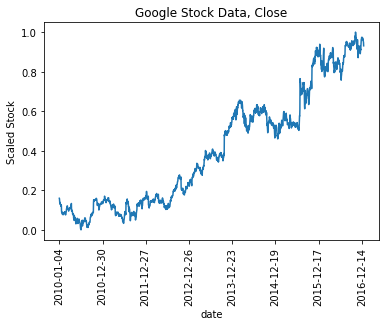

In [4]:
data_focus.close.plot(rot = 90)
plt.title('Google Stock Data, Close')
plt.ylabel('Scaled Stock')
plt.show()

In [5]:
# STEP 3 : Create Training set and Test set

def input_data(dataset, lookback):
    n_features = len(dataset.columns)
    dt_matrix = dataset.to_numpy()
    window_len = lookback + 1
    res = []
    
    for idx in range(len(dt_matrix) - window_len):
        res.append(dt_matrix[idx : idx + window_len])
        
    res = np.array(res)
    trainsize = int(0.7 * res.shape[0])
    train = res[:trainsize, :]
    
    X_train = train[:, :-1]
    y_train = train[:, -1][:, -1]
    X_test = res[trainsize:, : -1]
    y_test = res[trainsize:, -1][:, -1]
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_features))
    
    return [X_train, X_test, y_train, y_test]

# By this code, we choose a subset of dataset where the size of subset is given by window_len. 

window = 30
X_train, X_test, y_train, y_test = input_data(data_focus, window)
trainsize = y_train.shape[0]
testsize = y_test.shape[0]

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1211, 30, 5)
(520, 30, 5)
(1211,)
(520,)


In [7]:
# STEP 4 : Build a Model

n_features = len(data_focus.columns)
drop = 0.2
model = Sequential()
model.add(LSTM(256, input_shape = (window, n_features), return_sequences = True))
model.add(Dropout(drop))
model.add(LSTM(256, input_shape = (window, n_features), return_sequences = False))
model.add(Dropout(drop))
model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

2022-10-14 06:57:52.801110: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
# STEP 5 : Fit the model to data

model.fit(X_train,y_train,batch_size=512,epochs=100,validation_split=0.1,verbose=1)

2022-10-14 06:57:53.315294: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
3/3 [==============================] - 11s 1s/step - loss: 0.0394 - accuracy: 9.1827e-04 - val_loss: 9.2658e-04 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 3s 981ms/step - loss: 0.0303 - accuracy: 9.1827e-04 - val_loss: 0.0524 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 3s 947ms/step - loss: 0.0174 - accuracy: 9.1827e-04 - val_loss: 0.0235 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 3s 951ms/step - loss: 0.0122 - accuracy: 9.1827e-04 - val_loss: 0.0094 - val_accuracy: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 3s 971ms/step - loss: 0.0118 - accuracy: 9.1827e-04 - val_loss: 0.0150 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 4s 939ms/step - loss: 0.0101 - accuracy: 9.1827e-04 - val_loss: 0.0198 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 3s 940ms/step - loss: 0.0102 - accuracy: 9.1827e-04 -

In [9]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
testScore = model.evaluate(X_test, y_test, verbose=0)
p = model.predict(X_test)
print(trainScore, testScore)

[0.00770597904920578, 0.0008257638546638191] [0.0020725205540657043, 0.0]


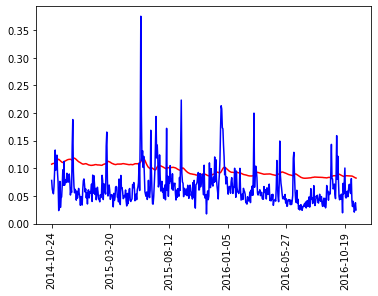

In [10]:
# STEP 6 : Visualize with Graph

dateList = list(data_focus.index)[trainsize:len(data_focus)-window-1]
ylist = list(y_test)
plist = list(p.reshape(-1))

ydf = pd.DataFrame(ylist, dateList)
ydf.columns = ['Actual Value']
pdf = pd.DataFrame(plist, dateList)
pdf.columns = ['Predict Value']

plt.plot(pdf,color='red', label='Prediction')
plt.plot(ydf,color='blue', label='Actual')
plt.xticks(np.arange(0,testsize,100), rotation=90)
plt.show()